C:\Users\arex8\AppData\Local\Temp\ipykernel_32268\999411761.py:49: RuntimeWarning: invalid value encountered in divide
  'theta':np.arctan(V / U), # Angle with the horizontal


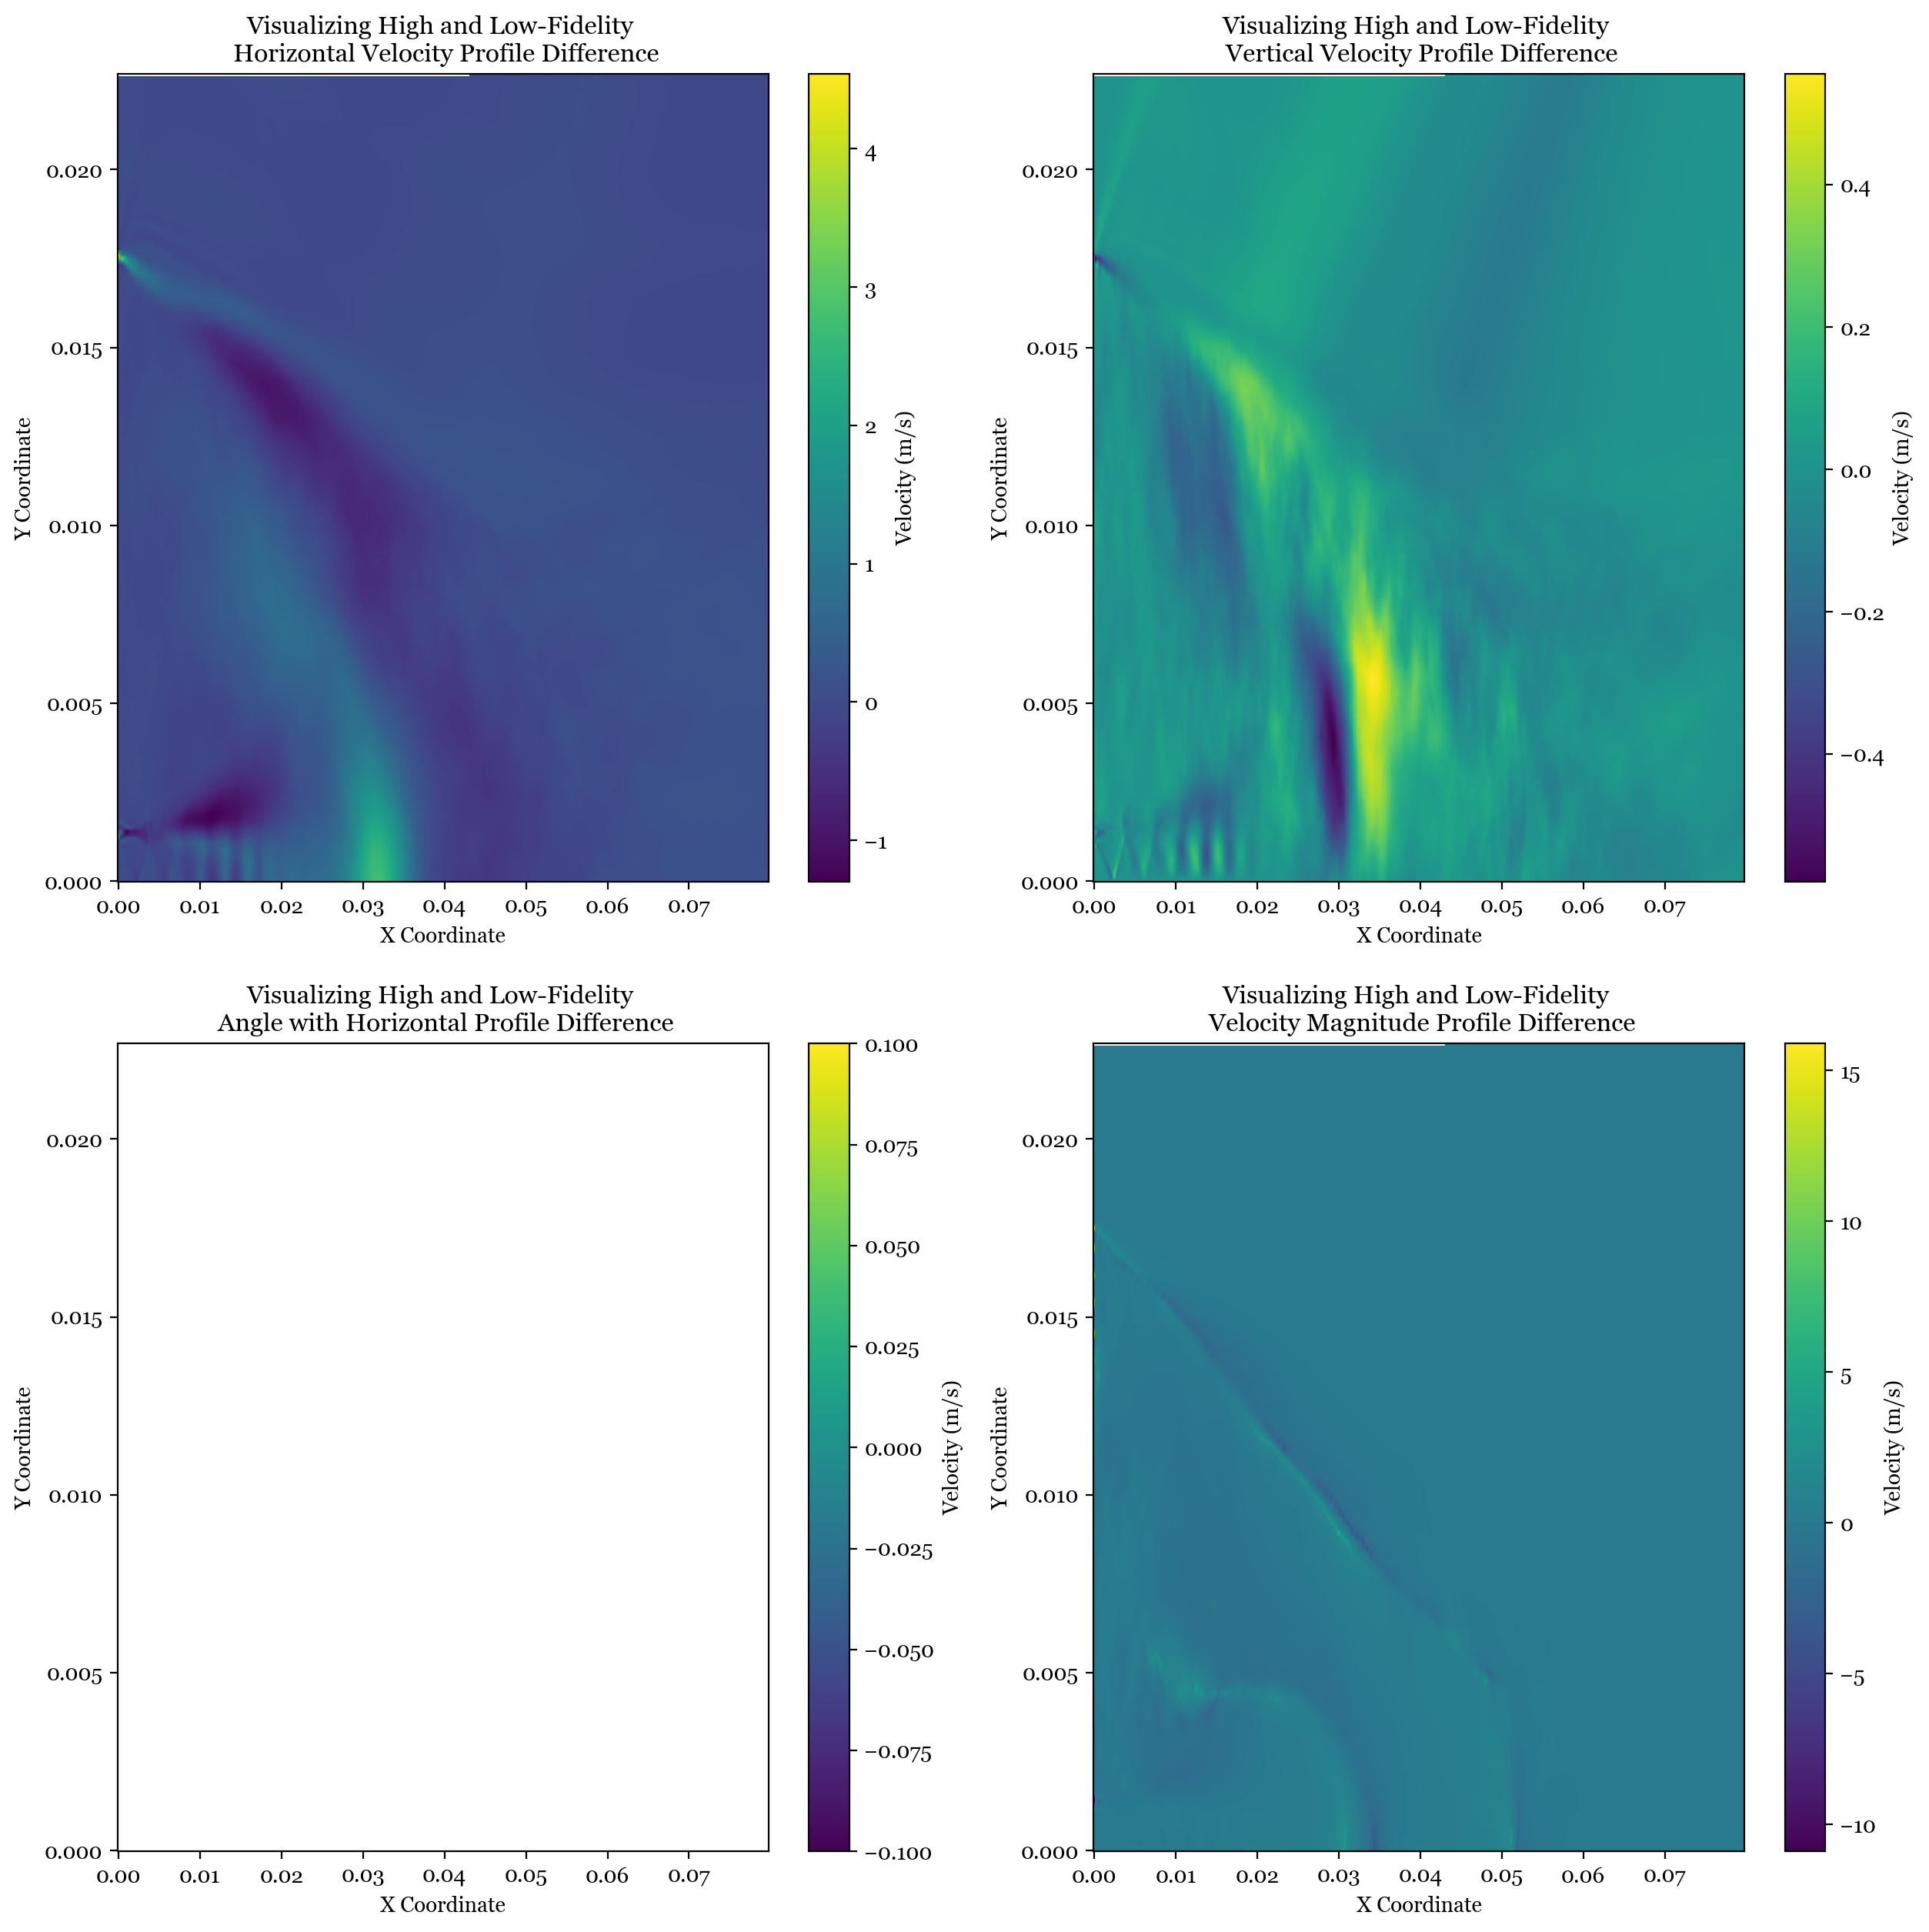

In [1]:
from util import * 

filenames = [
    'cbfh_RANS_velocity.dat',
    'cbfh_LES_dx0p500mm_velocity.dat',
    'cbfh_LES_dx0p250mm_velocity.dat',
    'cbfh_LES_dx0p177mm_velocity.dat',
    'cbfh_LES_dx0p125mm_velocity.dat'
]

# Perform gridded interpolations for comparing levels of fidelity
def to_grid(Xtest, Ytest, N_partitions=500):
    grid_x, grid_y = np.meshgrid(
        np.linspace(Xtest[:,0].min(), Xtest[:,0].max(), N_partitions),
        np.linspace(Xtest[:,1].min(), Xtest[:,1].max(), N_partitions)
    )

    grid_z = griddata((Xtest[:,0], Xtest[:,1]), Ytest, (grid_x, grid_y), method='cubic')

    return grid_x, grid_y, grid_z

# Function to read in the input files
def read_data(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            # Try to convert the line into 4 floats, skip if it fails
            parts = line.strip().split()
            if len(parts) == 4:
                try:
                    data.append([float(p) for p in parts])
                except ValueError:
                    continue  # skip lines that can't be parsed
    data = np.array(data)

    # Extract columns
    return data[:, :2], data[:, 2] , data[:, 3] 


data_dict = {} 

for level, file in enumerate(filenames):
    # Reading the data file 
    X, U, V = X, U, V = read_data('data/%s' % file)
    data_dict[level] = {
        'X':X, # XY coordinate as inputs to the model
        'U':U*0.01, # Horizontal component of velocity
        'V':V*0.01, # Vertical component of velocity
        'theta':np.arctan(V / U), # Angle with the horizontal
        'M':np.log(np.sqrt(U**2 + V**2) + 1e-5), # Computing the velocity magnitude
        'noise_var':1e-8 # Adding a small noise variance
    }




plt.figure(figsize=(15,15), dpi = 200)

keys = ['U', 'V', 'theta', 'M']
labels = ['Horizontal Velocity', 'Vertical Velocity', 'Angle with Horizontal', 'Velocity Magnitude']

for i in range(4):
    # Getting interpolated grid data for each
    X, Y, Z1 = to_grid(data_dict[3]['X'], data_dict[3][keys[i]], N_partitions = 500)
    _, _, Z2 = to_grid(data_dict[4]['X'], data_dict[4][keys[i]], N_partitions = 500)
    
    # Computign QoI difference
    Z_delta = Z1 - Z2

    plt.subplot(2,2,i+1)
    plt.pcolormesh(X, Y, Z_delta, cmap = 'viridis')
    plt.colorbar(label = 'Velocity (m/s)')
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Visualizing High and Low-Fidelity \n %s Profile Difference" % labels[i])

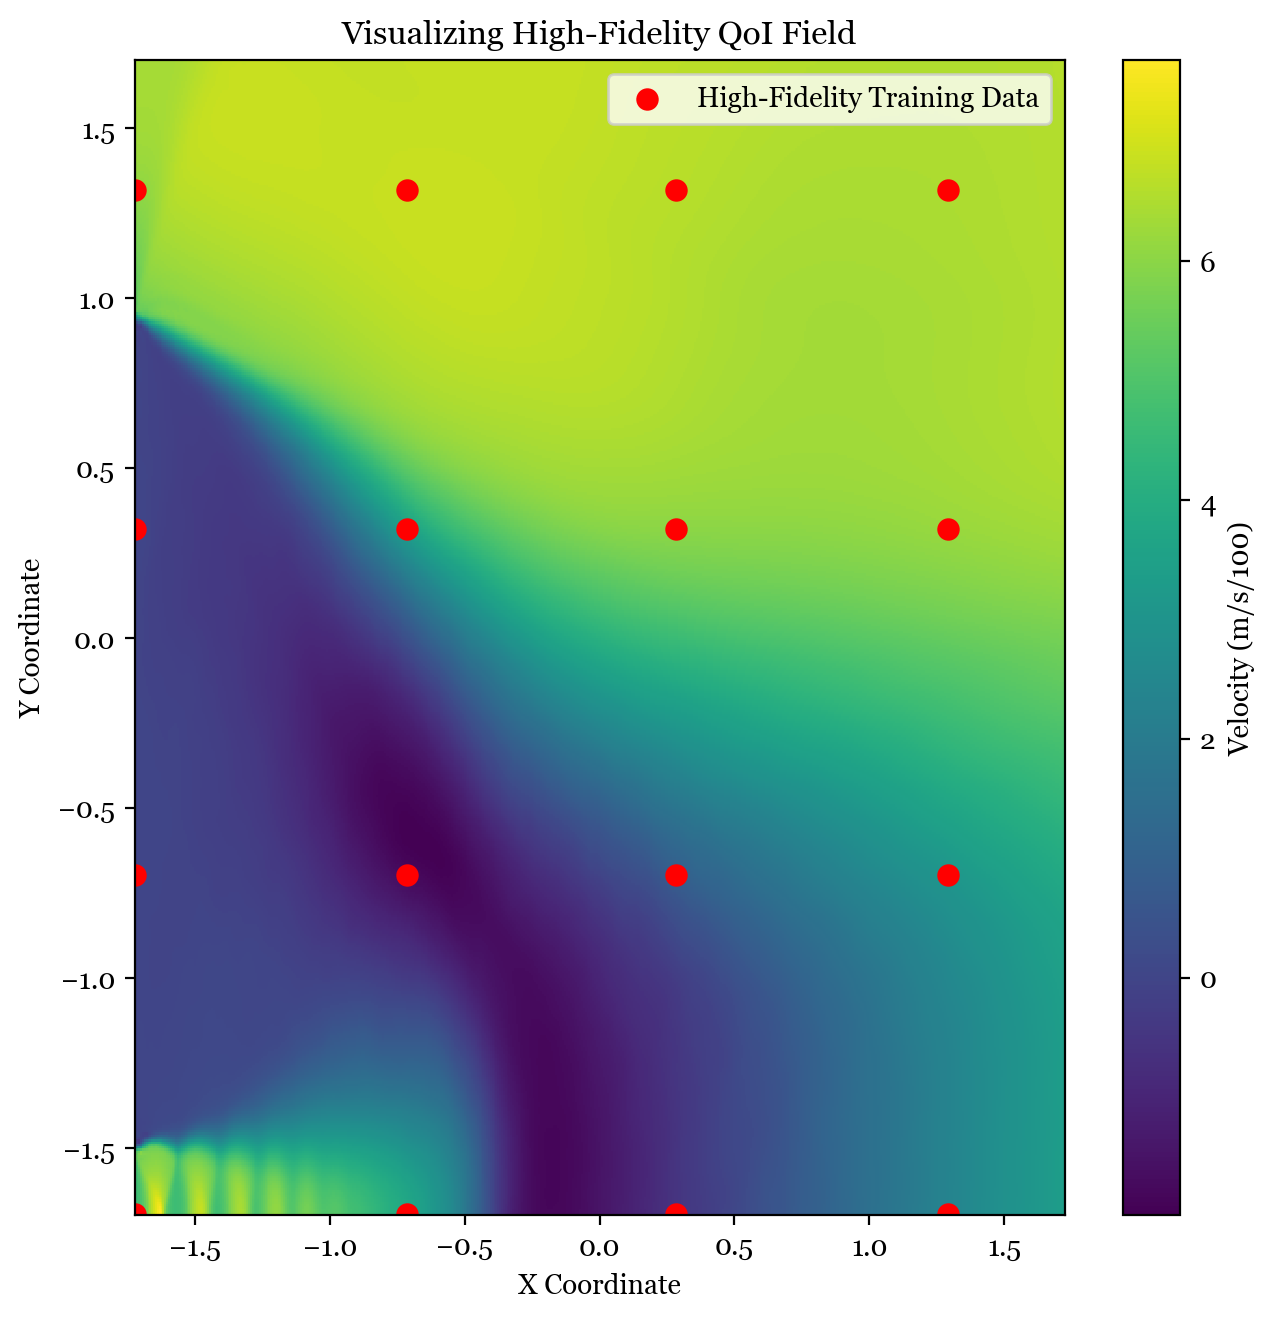

In [2]:
target_qoi = 'U'

# Picking out high-fidelity training data
partitions = 4
x_vals = np.linspace(0.00, 0.07, partitions)
y_vals = np.linspace(0.00, 0.02, partitions)

train_inds = []
tol = 7e-5

# Iterating through and choosing when X and Y are those values
for x_val in x_vals:
    for y_val in y_vals:
        these_inds = np.where((np.abs(data_dict[4]['X'][:,0] - x_val) < tol) & (np.abs(data_dict[4]['X'][:,1] - y_val) < tol))

        train_inds += list(these_inds[0].ravel())

# Selecting Xtrain and Ytrain
Xtrain = data_dict[4]['X'][train_inds,:]
Ytrain = data_dict[4][target_qoi][train_inds] 

# Processing the data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler = scaler.fit(data_dict[0]['X'])
Xtrain = scaler.transform(Xtrain)

QoIs = ['U', 'V', 'M']

for level in data_dict.keys():
    # Centering and scaling X and Y coordinates 
    data_dict[level]['X'] = scaler.transform(data_dict[level]['X'])
    # Centering and scaling QoIs by high-fidelity extreme values
    for QoI in QoIs:
        pass 
        #data_dict[level][QoI] *= 0.01





# Visualizing High-Fidelity training data 
plt.figure(figsize=(7.5,7.5), dpi = 200)
X, Y, Z = to_grid(data_dict[4]['X'], data_dict[4][target_qoi], N_partitions = 500)
plt.pcolormesh(X, Y, Z, cmap = 'viridis')
plt.colorbar(label = 'Velocity (m/s/100)')

plt.scatter(Xtrain[:,0], Xtrain[:,1], s = 50.0, c = 'red', label = "High-Fidelity Training Data")

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Visualizing High-Fidelity QoI Field")
plt.legend()


# Storing training and testing data
Xtest, Ytest = data_dict[4]['X'], data_dict[4][target_qoi]
data_dict[4]['X'], data_dict[4][target_qoi] = Xtrain, Ytrain

In [3]:
# Determining which QoI will be output for hyperkriging model
for level in data_dict.keys():
    data_dict[level]['Y'] = np.copy(data_dict[level][target_qoi])



from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

U_KNN_models = {} 

# Creating features for high-fidelity regression
train_features = np.copy(Xtrain)
test_features = np.copy(Xtest)

for level in range(4):
    # Declaring new K Nearest Neighbors Classifier
    model = KNeighborsRegressor(n_neighbors = 3, weights = 'uniform')
    # model = MLPRegressor(
    #     hidden_layer_sizes=(100, 100, 100),
    #     activation='relu',
    #     solver = 'adam', 
    #     max_iter = 500, learning_rate_init = 1e-2, verbose=True, 
    #     n_iter_no_change = 50
    # )
    
    # Fitting the model to the training data
    model.fit(data_dict[level]['X'], data_dict[level][target_qoi])

    # Storing the model in the dictionary
    U_KNN_models[level] = model

    # Making train and test predictions 
    train_pred, test_pred = model.predict(Xtrain), model.predict(Xtest)

    train_features = np.hstack((train_features, train_pred.reshape(-1,1)))
    test_features = np.hstack((test_features, test_pred.reshape(-1,1)))

Text(0.5, 1.0, 'True Simulation')

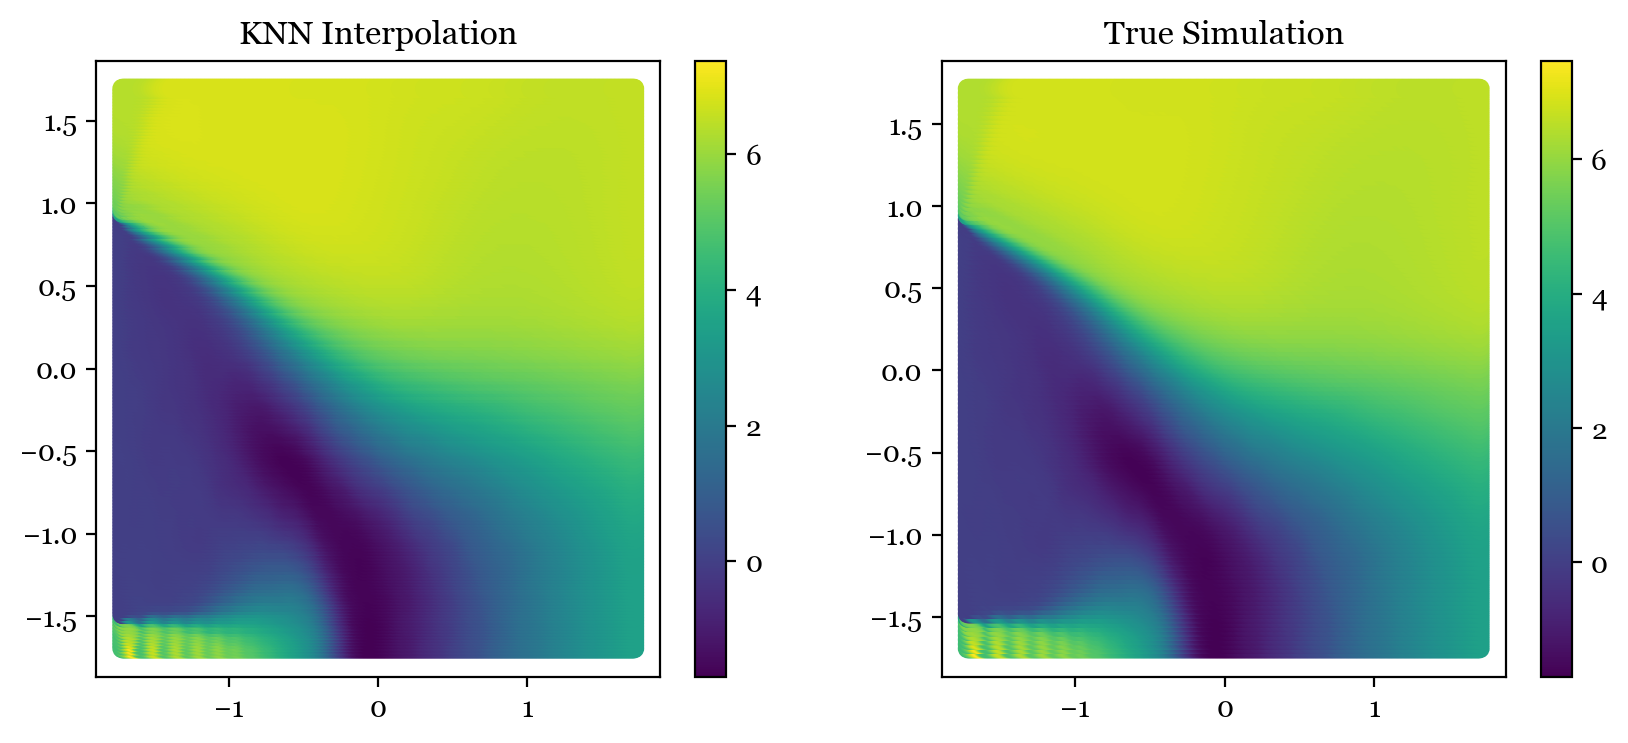

In [4]:
plt.figure(figsize=(10,4), dpi = 200)
plt.subplot(1,2,1)
plt.scatter(Xtest[:,0], Xtest[:,1], c = test_pred, cmap = 'viridis')
plt.title("KNN Interpolation")
plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(data_dict[3]['X'][:,0], data_dict[3]['X'][:,1], c = data_dict[3][target_qoi], cmap = 'viridis')
plt.colorbar()
plt.title("True Simulation")

In [5]:
# Creating a high-fidelity Kriging model with multi-fidelity features
hk_model = SimpleGP(train_features, Ytrain, rbf, 7, noise_var = 1e-6, jitter = 1e-5)

In [30]:
hk_model.optimize(
    params_to_optimize=['k_param'], lr = 2e1, epochs = 2500, beta1 = 0.9, beta2 = 0.999, batch_size = 250, shuffle = False
)

100%|██████████| 2500/2500 [00:23<00:00, 105.52it/s, Loss: -15.63283, LR: 2.00e+01]


In [31]:
from sklearn.metrics import mean_absolute_error as MAE 
hk_mean = hk_model.mean(test_features) 
print("Hyperkriging MAE:    %.5f" % MAE(Ytest, hk_mean))
print("Medium-Fidelity MAE: %.5f" % MAE(Ytest, test_pred))

Hyperkriging MAE:    0.14268
Medium-Fidelity MAE: 0.16216


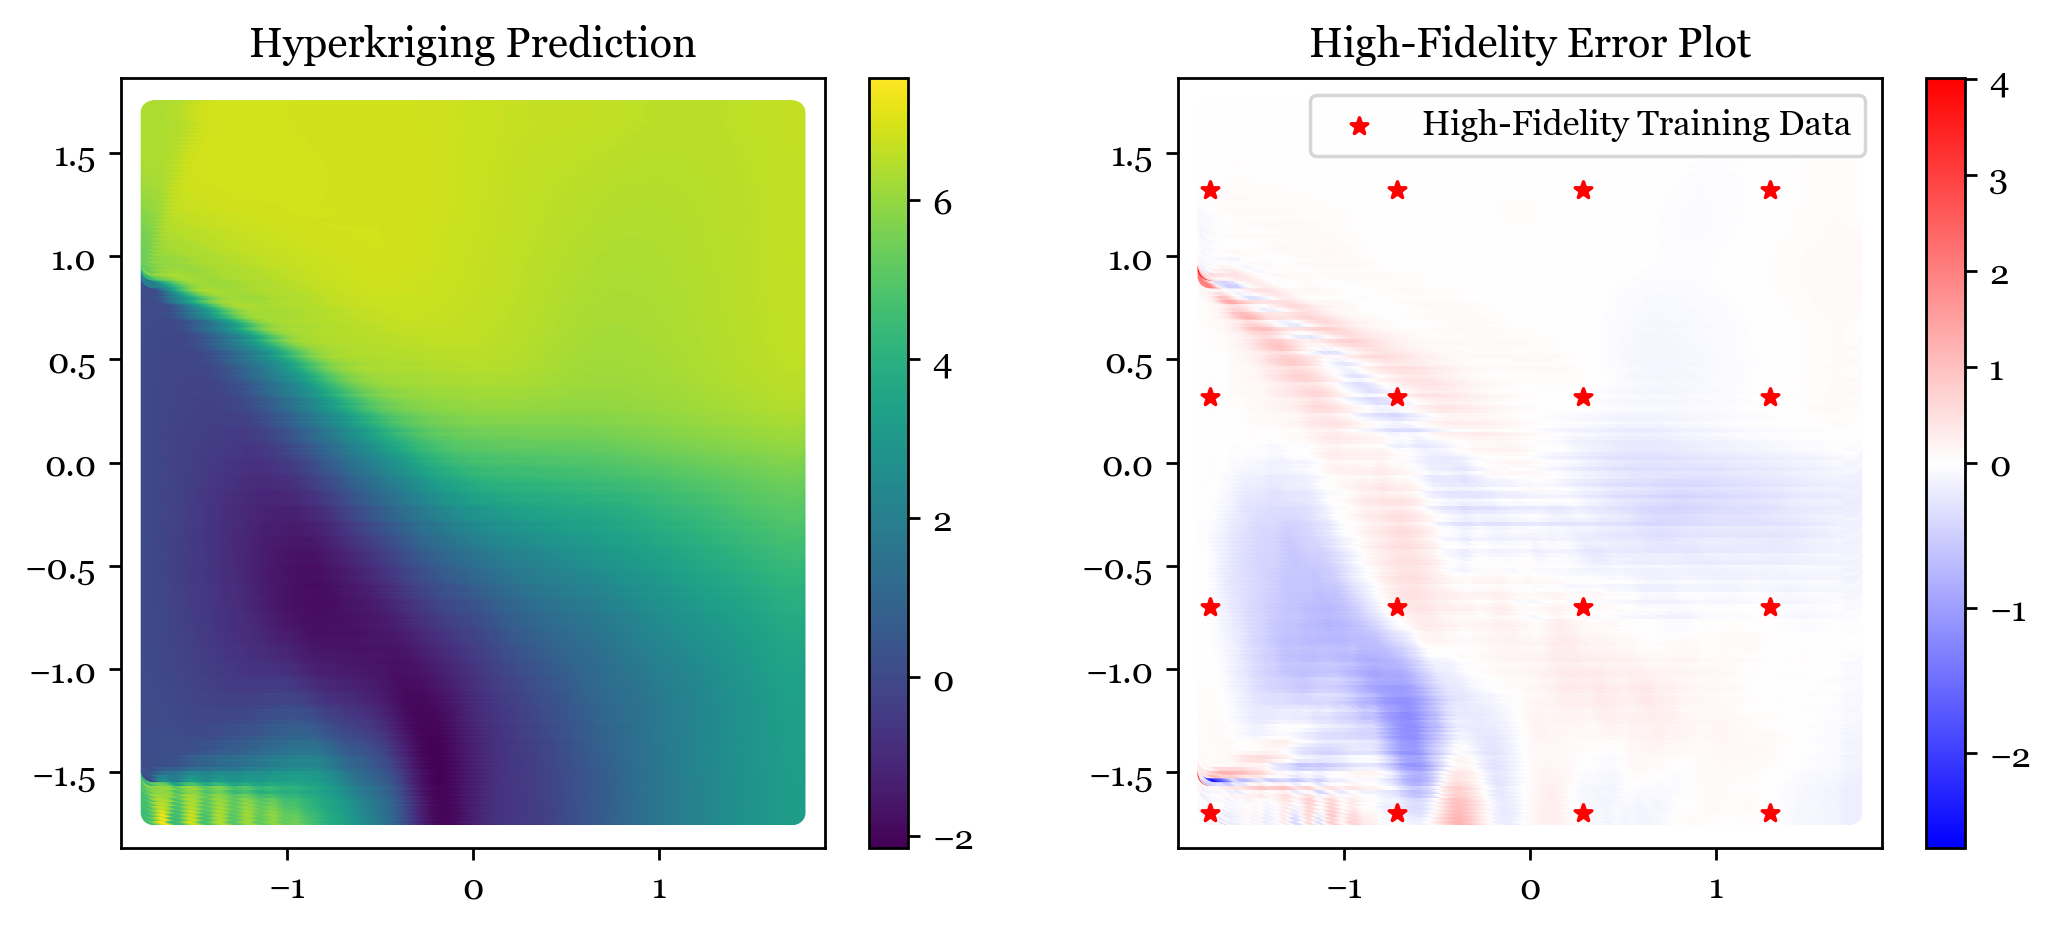

In [32]:
# Making predictions on test features
plt.figure(figsize=(10,4), dpi = 250)

plt.subplot(1,2,1)
plt.title("Hyperkriging Prediction")

plt.scatter(Xtest[:,0], Xtest[:,1], c = hk_mean, cmap = 'viridis')
plt.colorbar()

plt.subplot(1,2,2)
from matplotlib.colors import TwoSlopeNorm
diff = hk_mean - Ytest
norm = TwoSlopeNorm(vmin=diff.min(), vcenter=0, vmax=diff.max())
plt.scatter(Xtest[:,0], Xtest[:,1], c = hk_mean - Ytest, cmap = 'bwr', norm = norm)
plt.colorbar()
plt.title("High-Fidelity Error Plot")
plt.scatter(Xtrain[:,0], Xtrain[:,1], c = 'red', s = 25, marker = '*', label = "High-Fidelity Training Data")
plt.legend()

In [ ]:
kr_model = SimpleGP(Xtrain, Ytrain, rbf, 3, noise_var = 1e-6, jitter = 1e-6)
kr_model.optimize(
    params_to_optimize=['k_param'], 
    lr = 1e-1, epochs = 1000, 
    beta1 = 0.9, beta2 = 0.999, batch_size = 250, shuffle = False
)

kr_mean, kr_cov = kr_model.predict(Xtest)
kr_conf = 2 * np.sqrt(np.diag(kr_cov))

100%|██████████| 1000/1000 [00:07<00:00, 126.58it/s, Loss: 15.15218, LR: 1.00e-01]


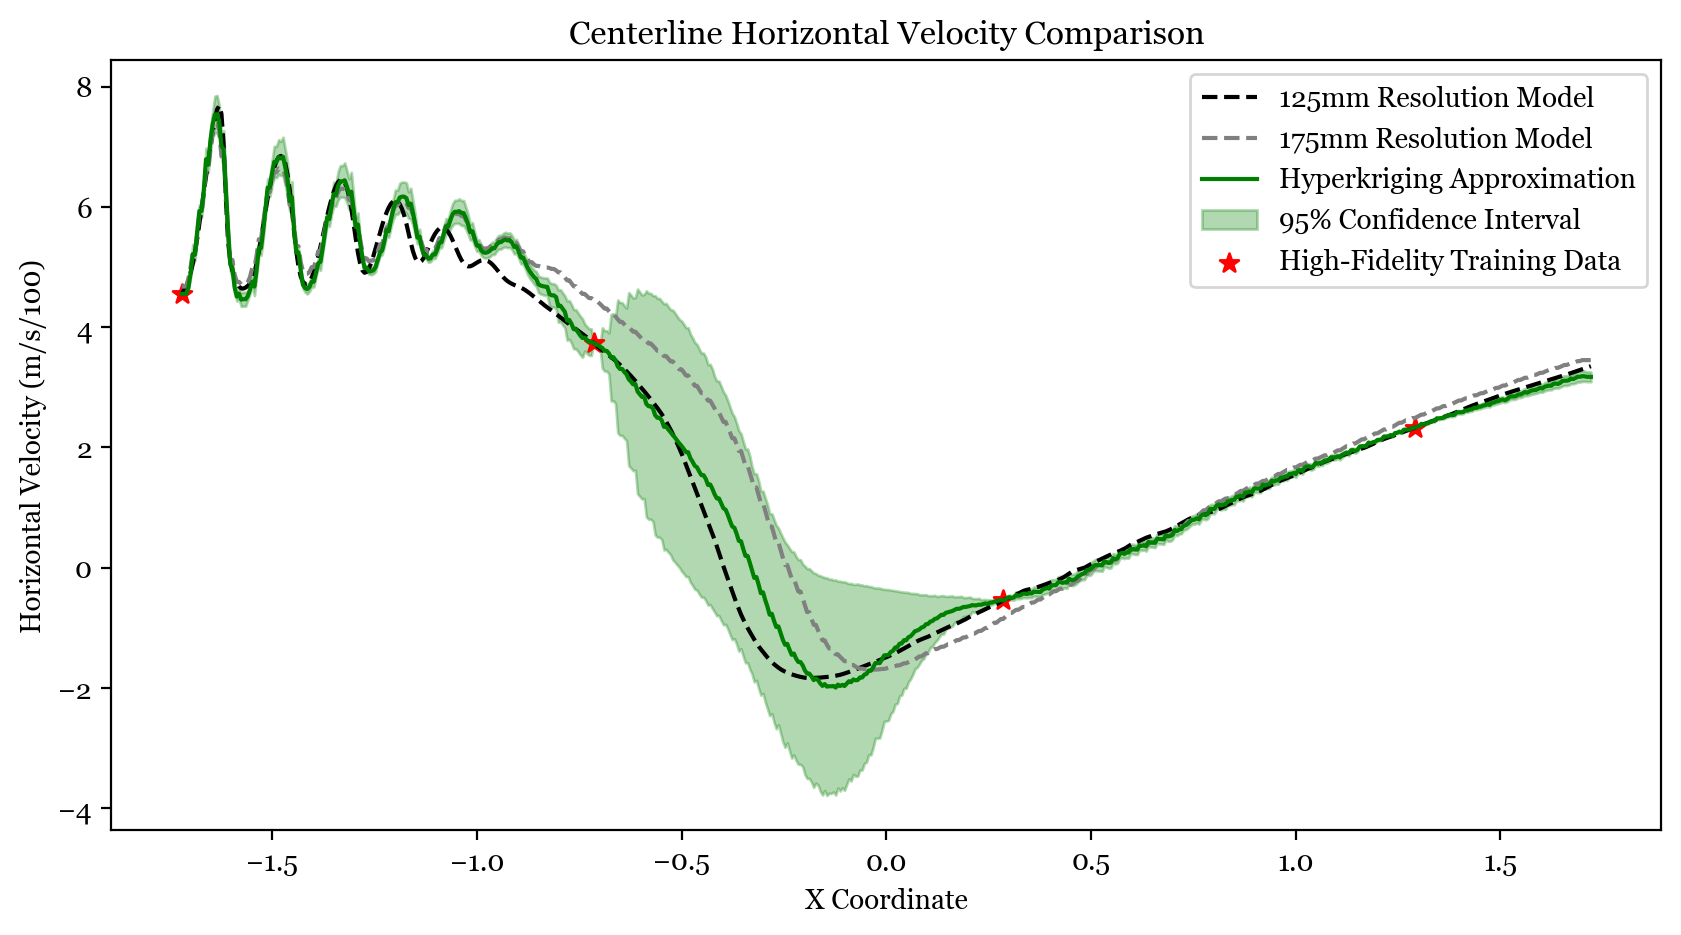

In [37]:
Xjet, Yjet, Fjet = Xtest[Xtest[:,1] == Xtest[:,1].min(),:], Ytest[Xtest[:,1] == Xtest[:,1].min()], test_features[Xtest[:,1] == Xtest[:,1].min(), :]

hk_jet, cov_jet = hk_model.predict(Fjet)
conf = 2*np.sqrt(np.diag(cov_jet))

plt.figure(figsize=(10,5), dpi = 200)
plt.plot(Xjet[:,0], Yjet, label = "125mm Resolution Model", color = 'black', linestyle = 'dashed')
plt.plot(Xjet[:,0], test_features[Xtest[:,1] == Xtest[:,1].min(),5], label = "175mm Resolution Model", color = 'gray', linestyle = 'dashed')
plt.plot(Xjet[:,0], hk_jet, label = "Hyperkriging Approximation", color = 'green')
plt.fill_between(Xjet[:,0], hk_jet - conf, hk_jet + conf, color = 'green', alpha = 0.3, label = "95% Confidence Interval")
plt.scatter(Xtrain[Xtrain[:,1] == Xtrain[:,1].min(), 0], Ytrain[Xtrain[:,1] == Xtrain[:,1].min()], marker = '*', color = 'red', label = 'High-Fidelity Training Data', s = 50.0)
plt.xlabel("X Coordinate")
plt.ylabel("Horizontal Velocity (m/s/100)")
plt.title("Centerline Horizontal Velocity Comparison")
plt.legend()